# Comparison of UTA and Promethee II

Zuzanna Buchnajzer 148280

## Imports

In [38]:
import pandas as pd
import numpy as np
from copy import deepcopy
import plotly.express as px
from pulp import LpVariable, LpProblem, LpMinimize,GLPK,LpStatus,LpMaximize
import pulp
import matplotlib.pyplot as plt

## Dataset
Dataset is exactly the same as in the previous project.

In [39]:
url = 'https://raw.githubusercontent.com/imohitmayank/ranking_algorithm_intro/master/cars_multi.csv'
df = pd.read_csv(url).sample(15,random_state=200)
df_id = df[['ID']]
df_id = df_id.dropna()
df_id = df_id.reset_index(drop = True)
df =  df[['mpg','horsepower', 'weight', 'acceleration', 'price']]
df = df.dropna()
df = df[df.horsepower != '?']
df['horsepower'] = df.horsepower.astype(int)
df = df.reset_index(drop = True)

### Preferential information
- All those preferential informations are for Promethee II method.
- UTA method doesn't requaire any preferential information, however we are using type of category to change slightly the dataset.

In [40]:
q = [5, 40, 400, 1, 3000]
p = [12, 80, 800,  3, 7000]
v = [20,140, 1700, 8, 20000]
weights = np.array([4.,1., 1., 3., 5.])
cat_type = ['gain','gain','gain','gain','cost']
qpv = pd.DataFrame([q,p,v,cat_type], columns = df.columns, index = ["q (indifference)","p (preference)","v (veto)","type_of cathegory"])

## UTA


In [41]:
class UTA():
    def __init__(self, lista, df):
        
        #datasets
        self.df = df
        self.lista = lista
        
        #weights for each category are store as LpVariable
        self.weights = []
        for col in self.df:
            self.weights.append(LpVariable("w_"+col, 0, 1))
        
        # relaxation is a list of binary LpVariables, that are appended here automaticaly, when the constraint is added.
        # When some constraints contradict each other, value of relaxation variable is equal to one. 
        # It means that this constraint was removed to obtain a feasible solution.
        self.relaxations = []
        
        # problem initialization
        self.prob = LpProblem("myProblem", LpMinimize)
        
        # normalization of weights
        self.prob += sum(self.weights) == 1.
        
    # method to get U    
    def get_U(self, index):
        return sum(np.array(self.lista[index]) * np.array(self.weights))
    
    # method to get U as a number    
    def get_final_U(self, index):
        values = [v.value() for v in self.weights]
        return sum(np.array(self.lista[index]) * np.array(values))

    # method to add new constraint in form of in the form a >= b
    def add_constraint(self, index_a, index_b):
        
        var = LpVariable("rel_"+str (index_a) + '_'+str(index_b), 0 , 1, cat = 'Integer')
        
        self.relaxations.append(var)
        
        self.prob += self.get_U(index_a) >= self.get_U(index_b) - var
        
    # method is added to mimic the exercise on labs, that there should not be a weights that is bigger the sum of other
    def add_constraint_triange(self, indexes_a, indexes_b, cat_type = 'gain'):
        
        var = LpVariable("triangle"+str(len(self.relaxations)),0,1, cat = 'Integer')
        
        self.relaxations.append(var)
        
        self.prob += sum([self.weights[index_x] for index_x in indexes_a]) >= sum([self.weights[index_x]- var for index_x in indexes_b]) 
  
    # method that creates Kendal matrix based on previously solved weights
    def get_Kendal_matrix(self):
        back_up_weights = deepcopy(self.weights)
        self.weights = [w.value() for w in self.weights]
        n = len(self.lista)
        matrix = np.zeros([n,n], np.float32)
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                U_i = self.get_U(i)
                U_j = self.get_U(j)
                if U_i>U_j:
                    matrix[i,j] = 1.
                elif U_i == U_j:
                    matrix[i,j] = 1/2
        self.weights = back_up_weights
        return matrix
    
    # method that shows the plots of utility function for each criteria
    def show_plots(self):
        for v in self.weights:
            col = v.name[2:]
            print(col)
            print(v, v.value())

            x = [min(self.df[col]),max(self.df[col])]

            if col =='price':
                y = [v.value(),0]
            else:
                y = [0, v.value()]
            plt.ylim(0,1)
            plt.plot(x, y)

            plt.xlabel('Range of '+col)
            plt.ylabel('Utility funtion')

            plt.title(col)
            plt.show()
    
    # method that is solving the problem based on added constraints and variables. 
    def solve(self):
        self.prob += sum(self.relaxations)
        status = self.prob.solve()
        print("Objective: " , self.prob.objective, " = ", self.prob.objective.value())
        for v in self.weights:
            print(v, v.value())
        for v in self.relaxations:
            print(v, v.value())
        return status


In [42]:
# normalize and apply changes for cost type functions
def prepare_dataset(df, cat_type):
    u=(df-df.min())/(df.max()-df.min())
    for index, col in enumerate(df):
        if cat_type[index] == 'cost':
            u[col]=1-u[col] 
    return u
u = prepare_dataset(df, cat_type)

#### UTA with contradictory constraints

- Prepare a program implementing the UTA method with solving inconsistency by binary variables using a solver (e.g. GLPK in the pulp library).
- As preferential information, consider pairwise comparisons prepared in the previous project, enriched with additional pairwise comparisons.
- At least one constraint resulting from the preferential information should be inconsistent with the rest and be rejected by the solver.
- Find all subset of inconsistent preferential information. (last two constraints)


In [43]:
uta = UTA(u.values, u)

uta.add_constraint(2,9)
uta.add_constraint(4,9)
uta.add_constraint(9,5)
uta.add_constraint(6,1)
uta.add_constraint(14,0)
uta.add_constraint(0,7)
uta.add_constraint(12,3)
uta.add_constraint(3,13)

# #wrong constraints - UTA will characterize them well as contradictory and their variables will be equal to 1. 
uta.add_constraint(13,2)
uta.add_constraint(0,4)

uta.add_constraint_triange([1,2,3,4],[0])
uta.add_constraint_triange([0,2,3,4],[1])
uta.add_constraint_triange([0,1,3,4],[2])
uta.add_constraint_triange([0,1,2,4],[3])
uta.add_constraint_triange([0,1,2,3],[4])

status = uta.solve()


Objective:  rel_0_4 + rel_0_7 + rel_12_3 + rel_13_2 + rel_14_0 + rel_2_9 + rel_3_13 + rel_4_9 + rel_6_1 + rel_9_5 + triangle10 + triangle11 + triangle12 + triangle13 + triangle14  =  2.0
w_mpg 0.39710732
w_horsepower 0.0
w_weight 0.11146588
w_acceleration 0.0
w_price 0.49142681
rel_2_9 0.0
rel_4_9 0.0
rel_9_5 0.0
rel_6_1 0.0
rel_14_0 0.0
rel_0_7 0.0
rel_12_3 0.0
rel_3_13 0.0
rel_13_2 1.0
rel_0_4 1.0
triangle10 0.0
triangle11 0.0
triangle12 0.0
triangle13 0.0
triangle14 0.0


#### UTA without contradictory constraints
For one consistent model:
- List all the equations in the model and all the variables with their values obtained during the optimization.
- Print the value of the objective function.
- Draw plots of marginal utility functions. All plots should be scaled to the same maximum utility value. All axes should be described.
- Discuss the results.

Objective:  rel_0_7 + rel_12_3 + rel_14_0 + rel_2_9 + rel_3_13 + rel_4_9 + rel_6_1 + rel_9_5 + triangle10 + triangle11 + triangle12 + triangle8 + triangle9  =  0.0
w_mpg 0.33959949
w_horsepower 0.0
w_weight 0.086076434
w_acceleration 0.12612711
w_price 0.44819697
rel_2_9 0.0
rel_4_9 0.0
rel_9_5 0.0
rel_6_1 0.0
rel_14_0 0.0
rel_0_7 0.0
rel_12_3 0.0
rel_3_13 0.0
triangle8 0.0
triangle9 0.0
triangle10 0.0
triangle11 0.0
triangle12 0.0

----All variables and constraints---
myProblem:
MINIMIZE
1*rel_0_7 + 1*rel_12_3 + 1*rel_14_0 + 1*rel_2_9 + 1*rel_3_13 + 1*rel_4_9 + 1*rel_6_1 + 1*rel_9_5 + 1*triangle10 + 1*triangle11 + 1*triangle12 + 1*triangle8 + 1*triangle9 + 0
SUBJECT TO
_C1: w_acceleration + w_horsepower + w_mpg + w_price + w_weight = 1

_C2: rel_2_9 - 0.806722689076 w_acceleration - 0.075 w_horsepower
 + 0.282786885246 w_mpg + 0.107413586973 w_price - 0.492900608519 w_weight
 >= 0

_C3: rel_4_9 - 0.991596638655 w_acceleration + 0.1625 w_horsepower
 + 0.360655737705 w_mpg + 0.167109636

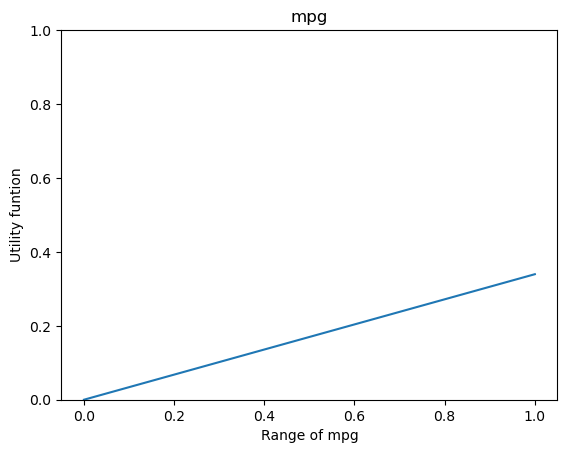

horsepower
w_horsepower 0.0


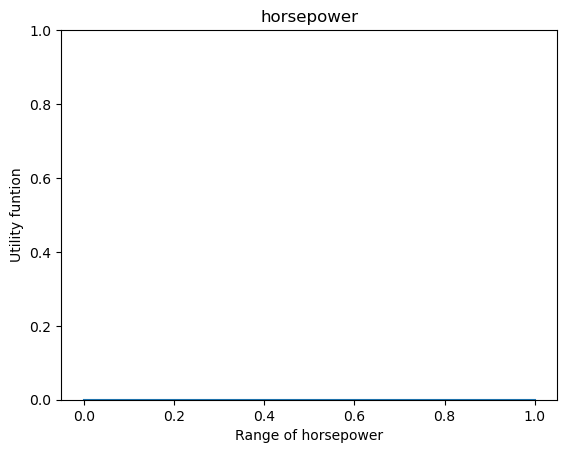

weight
w_weight 0.086076434


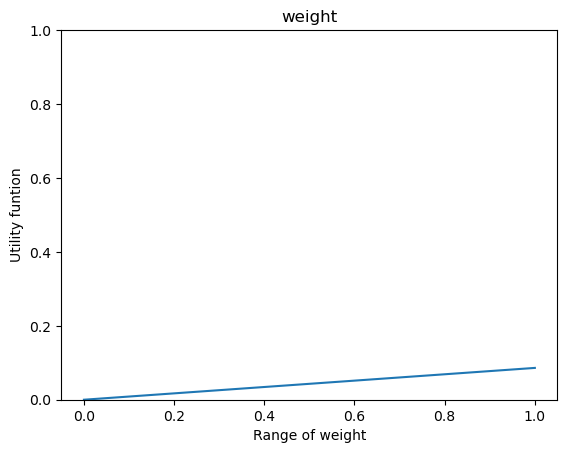

acceleration
w_acceleration 0.12612711


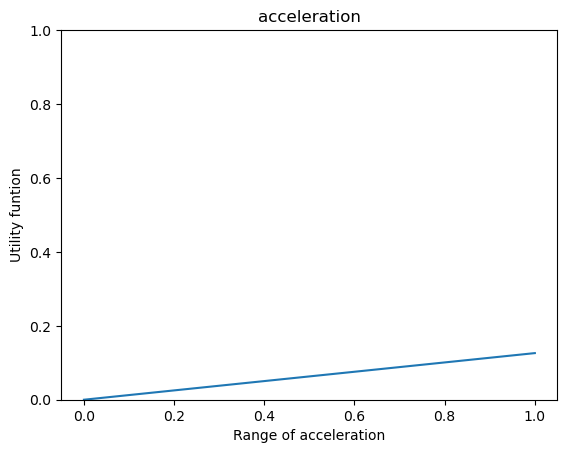

price
w_price 0.44819697


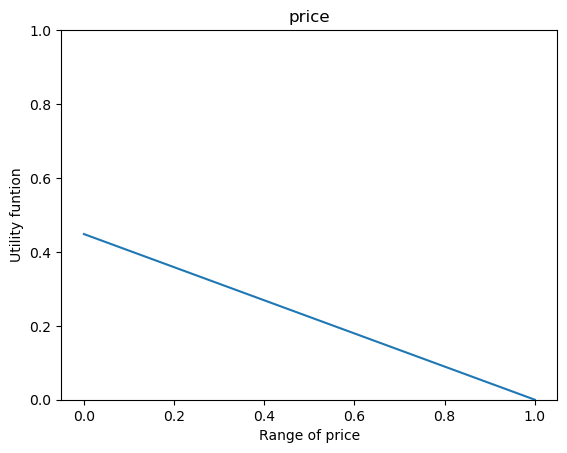

In [44]:
uta = UTA(u.values, u)

uta.add_constraint(2,9)
uta.add_constraint(4,9)
uta.add_constraint(9,5)
uta.add_constraint(6,1)
uta.add_constraint(14,0)
uta.add_constraint(0,7)
uta.add_constraint(12,3)
uta.add_constraint(3,13)


uta.add_constraint_triange([1,2,3,4],[0])
uta.add_constraint_triange([0,2,3,4],[1])
uta.add_constraint_triange([0,1,3,4],[2])
uta.add_constraint_triange([0,1,2,4],[3])
uta.add_constraint_triange([0,1,2,3],[4])

status = uta.solve()
print("\n----All variables and constraints---")
print(uta.prob)
uta.show_plots()

### PROMETHEE II

In [45]:
class Promethee:
    def __init__(self, qpv,cat_type, weights, df):
        # dataset
        self.df = df

        # preferential informations
        self.qpv = qpv
        self.cat_type = cat_type
        
        #weights normalization
        weights = [np.array(weights/sum(weights)).transpose()]
        weights=pd.DataFrame(weights, index=["weight"], columns = df.columns)
        self.weights = weights
    
    # method for preference matrix (Kendal)
    def get_matrix(self):
        out = np.zeros((len(self.pos), len(self.pos)))
        for (pos_i, i), (neg_i, _) in zip(self.pos, self.neg):
            for (pos_j, j), (neg_j, _) in zip(self.pos, self.neg):
                if pos_i - neg_i > pos_j - neg_j:
                    out[i][j] = 1
                elif  (pos_i - neg_i == pos_j - neg_j) and (i != j):
                    out[i][j] = 0.5
        return out    
        
                
#rest are just util functions to compute PROMETEE I and II (mostly from the first project)
    def preference_function(self, a, b, qpv_c , reverse = False):
        if reverse is True:
            a,b = b,a
        q, p, v, category_type = qpv_c
        if category_type == "gain":
            d = a-b
        elif category_type == "cost":
            d = b-a
            
        if d > p:
            return 1
        elif d <= q:
            return 0
        else:
            return (d-q)/(p-q)

    def marginal_preference_indices(self, criteria):
        out = np.zeros((len(self.df), len(self.df)), dtype = np.float64)
        for i, di in self.df.iterrows():
            for j, dj in self.df.iterrows():
                out[i][j] += self.preference_function(di[criteria], dj[criteria], self.qpv[criteria])
        return np.array(out)

    def comprehensive_preference_indices(self):
        out = np.zeros((len(self.df), len(self.df)))
        criterias = self.df.columns
        for c in criterias:
            out += self.marginal_preference_indices(c) * self.weights[c]["weight"]
        return out
    
    def get_flows(self):
        cpi = self.comprehensive_preference_indices()
        pos_flow = list(cpi.sum(1))
        neg_flow = list(cpi.sum(0))
        pos = list(zip(pos_flow, [c for c in range(len(self.df))]))
        neg = list(zip(neg_flow, [c for c in range(len(self.df))]))
        self.pos = pos
        self.neg = neg
        return pos, neg

In [48]:
prom = Promethee( qpv,cat_type, weights, df)
pos, neg = prom.get_flows()
prom.get_matrix()


array([[0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0.

## Comparison between UTA and Promethee using Kendal coefficient
In addition, we examined the weights introduced in Promethee, as well as those provided by UTA.

In [49]:
# function to compare matrices using Kendal coefficient
def Kendal_coefficient(promethee_matrix, uta_matrix):
    d = np.sum(abs(promethee_matrix - uta_matrix))/2
    tau = 1-4*d/len(uta_matrix)/(len(uta_matrix)-1)
    return tau

def weight_comparison(promethee_weights, uta_weights, col):
    mse = ((promethee_weights - uta_weights)**2).mean(axis=0)
    df_weights = pd.DataFrame([promethee_weights, uta_weights], index = ['original', 'predicted by UTA'], columns=col)
    return mse,df_weights

Since the tau value varies between -1 for opposite matrices and 1 for the same ones, the result of about 0.75 confirms the similarity in results between the UTA and Promethee method.

In [50]:
prom_m = prom.get_matrix()
uta_m = uta.get_Kendal_matrix()
tau =Kendal_coefficient(prom_m, uta_m)
mse, w = weight_comparison(weights/sum(weights),np.array([v.value() for v in uta.weights]), df.columns)

print("Kendal tau: ", tau )
print()
print("Mean Squared error for weights predicted by UTA", mse)
w

Kendal tau:  0.7142857142857143

Mean Squared error for weights predicted by UTA 0.004856601382591523


,mpg,horsepower,weight,acceleration,price
original,0.285714,0.071429,0.071429,0.214286,0.357143
predicted by UTA,0.339599,0.000000,0.086076,0.126127,0.448197


In [51]:
ranking = [[v, uta.get_final_U(v)] for v in range(len(u))]
comp = deepcopy(df)
comp['U'] = [uta.get_final_U(v) for v in range(len(u))]
comp.sort_values(by = ['U'], ascending=False, inplace = True)
comp

,mpg,horsepower,weight,acceleration,price,U
4,36.0,84,2370,13.0,17421.626900,0.666320
9,27.2,71,3190,24.8,24639.374040,0.622645
2,34.1,65,1975,15.2,20000.000000,0.622645
1,36.0,75,2205,14.5,30000.000000,0.545932
6,15.0,145,4440,14.0,8844.146509,0.545932
14,39.4,70,2070,18.6,40000.000000,0.528226
8,26.0,93,2391,15.5,26414.508270,0.461052
7,37.0,92,2434,15.0,47697.077160,0.389505
0,24.0,110,2660,14.0,30000.000000,0.389505
10,27.2,97,2300,14.7,35110.419720,0.375860


In [52]:
prom_ranking = np.array(pos)[:,0]- np.array(neg)[:,0]
rank = pd.DataFrame(prom_ranking,columns=['prom']).sort_values(by = ['prom'], ascending=False)
rank

,prom
9,5.339734
2,4.380570
4,4.337500
6,2.290561
14,2.158330
1,1.758992
8,0.908257
12,-1.209730
0,-1.305192
11,-1.567975


## Conclusions
Fortunately, the best and worst cases mostly match those pointed out by promethee and our intuition.
Probably because our uta has no breakpoints, it attempts to choose such weights to fit the specified preference as best it can. 
If this uta method achieves weights similar enough to promethee, the order will also be similar.

## Experiments
- Added all preferences created by Promethee to UTA.

In [53]:
uta_all = UTA(u.values, u)
for row in range(len(prom_m)):
    for col in range(len(prom_m)):
        if prom_m[row][col]==1:
            uta_all.add_constraint(row,col)

uta_all.solve()

Objective:  rel_0_10 + rel_0_11 + rel_0_13 + rel_0_3 + rel_0_5 + rel_0_7 + rel_10_13 + rel_10_3 + rel_10_7 + rel_11_10 + rel_11_13 + rel_11_3 + rel_11_5 + rel_11_7 + rel_12_0 + rel_12_10 + rel_12_11 + rel_12_13 + rel_12_3 + rel_12_5 + rel_12_7 + rel_13_3 + rel_14_0 + rel_14_1 + rel_14_10 + rel_14_11 + rel_14_12 + rel_14_13 + rel_14_3 + rel_14_5 + rel_14_7 + rel_14_8 + rel_1_0 + rel_1_10 + rel_1_11 + rel_1_12 + rel_1_13 + rel_1_3 + rel_1_5 + rel_1_7 + rel_1_8 + rel_2_0 + rel_2_1 + rel_2_10 + rel_2_11 + rel_2_12 + rel_2_13 + rel_2_14 + rel_2_3 + rel_2_4 + rel_2_5 + rel_2_6 + rel_2_7 + rel_2_8 + rel_4_0 + rel_4_1 + rel_4_10 + rel_4_11 + rel_4_12 + rel_4_13 + rel_4_14 + rel_4_3 + rel_4_5 + rel_4_6 + rel_4_7 + rel_4_8 + rel_5_10 + rel_5_13 + rel_5_3 + rel_5_7 + rel_6_0 + rel_6_1 + rel_6_10 + rel_6_11 + rel_6_12 + rel_6_13 + rel_6_14 + rel_6_3 + rel_6_5 + rel_6_7 + rel_6_8 + rel_7_13 + rel_7_3 + rel_8_0 + rel_8_10 + rel_8_11 + rel_8_12 + rel_8_13 + rel_8_3 + rel_8_5 + rel_8_7 + rel_9_0 + rel

1

In [54]:
prom_m = prom.get_matrix()
uta_all_m = uta_all.get_Kendal_matrix()
tau_all = Kendal_coefficient(prom_m, uta_all_m)
mse_all, w_all = weight_comparison(weights/sum(weights),np.array([v.value() for v in uta_all.weights]), df.columns)

print("Kendal tau: ", tau_all )
print()
print("Mean Squared error for weights predicted by UTA", mse_all)
w_all

Kendal tau:  0.9428571428571428

Mean Squared error for weights predicted by UTA 0.008702230969357906


,mpg,horsepower,weight,acceleration,price
original,0.285714,0.071429,0.071429,0.214286,0.357143
predicted by UTA,0.179906,0.006117,0.031187,0.274722,0.508067


- Added all 'direct' preferences created by Promethee to UTA (only those on the graph ie. with arrows).

In [55]:
uta_direct = UTA(u.values, u)

#direct preferences
uta_direct.add_constraint(2,9)
uta_direct.add_constraint(4,9)
uta_direct.add_constraint(9,1)
uta_direct.add_constraint(9,5)
uta_direct.add_constraint(9,14)
uta_direct.add_constraint(6,1)
uta_direct.add_constraint(6,5)
uta_direct.add_constraint(6,8)
uta_direct.add_constraint(6,14)
uta_direct.add_constraint(8,0)
uta_direct.add_constraint(14,0)
uta_direct.add_constraint(0,7)
uta_direct.add_constraint(0,11)
uta_direct.add_constraint(0,10)
uta_direct.add_constraint(7,12)
uta_direct.add_constraint(11,12)
uta_direct.add_constraint(12,3)
uta_direct.add_constraint(3,13)

# #wrong constraints
uta_direct.add_constraint(13,2)
uta_direct.add_constraint(0,4)

#solve
uta_direct.solve()


Objective:  rel_0_10 + rel_0_11 + rel_0_4 + rel_0_7 + rel_11_12 + rel_12_3 + rel_13_2 + rel_14_0 + rel_2_9 + rel_3_13 + rel_4_9 + rel_6_1 + rel_6_14 + rel_6_5 + rel_6_8 + rel_7_12 + rel_8_0 + rel_9_1 + rel_9_14 + rel_9_5  =  2.0
w_mpg 0.29157109
w_horsepower 0.1792653
w_weight 0.051631277
w_acceleration 0.046154873
w_price 0.43137745
rel_2_9 0.0
rel_4_9 0.0
rel_9_1 0.0
rel_9_5 0.0
rel_9_14 0.0
rel_6_1 0.0
rel_6_5 0.0
rel_6_8 0.0
rel_6_14 0.0
rel_8_0 0.0
rel_14_0 0.0
rel_0_7 0.0
rel_0_11 0.0
rel_0_10 0.0
rel_7_12 0.0
rel_11_12 0.0
rel_12_3 0.0
rel_3_13 0.0
rel_13_2 1.0
rel_0_4 1.0


1

In [56]:
prom_m = prom.get_matrix()
uta_direct_m = uta_direct.get_Kendal_matrix()
tau_direct = Kendal_coefficient(prom_m, uta_direct_m)
mse_direct, w_direct = weight_comparison(weights/sum(weights),np.array([v.value() for v in uta_direct.weights]), df.columns)

print("Kendal tau: ", tau_direct )
print()
print("Mean Squared error for weights predicted by UTA", mse_direct)
w_direct

Kendal tau:  0.6190476190476191

Mean Squared error for weights predicted by UTA 0.009166749924045692


,mpg,horsepower,weight,acceleration,price
original,0.285714,0.071429,0.071429,0.214286,0.357143
predicted by UTA,0.291571,0.179265,0.051631,0.046155,0.431377


In [57]:
conclusion_weight = pd.DataFrame([w.loc['original'], w.loc['predicted by UTA'],w_all.loc['predicted by UTA'], w_direct.loc['predicted by UTA']], index = ['original', 'UTA: normal', 'UTA: all preferences', 'UTA: direct preferences'])
conclusion_weight['mse'] = [0,mse, mse_all, mse_direct]
conclusion_weight['tau'] = [0,tau, tau_all, tau_direct]

conclusion_weight

,mpg,horsepower,weight,acceleration,price,mse,tau
original,0.285714,0.071429,0.071429,0.214286,0.357143,0.000000,0.000000
UTA: normal,0.339599,0.000000,0.086076,0.126127,0.448197,0.004857,0.714286
UTA: all preferences,0.179906,0.006117,0.031187,0.274722,0.508067,0.008702,0.942857
UTA: direct preferences,0.291571,0.179265,0.051631,0.046155,0.431377,0.009167,0.619048


### Summary
In summary, for different models, the weights are more or less similar to those selected for PROMETHEE by Decision Maker. 

At first it seemed strange that UTA_ normal, with half the constraints that direct_UTA had, was more similar to Promethee. However, this is as possible due to the different way UTA searches the solution space.